In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

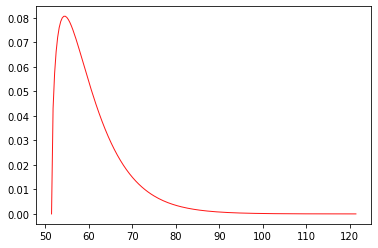

In [3]:
# distribution for the cost of BEP
loc = 51.42
mean = 60.42 - loc
a = 1.5
scale = mean/a
fig, ax = plt.subplots(1,1)
x = np.linspace(loc, loc+(120-50), 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
plt.show()

In [4]:
%cd '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/india/2020_10_16_08_59_11/count_data/'
%ls

/ihme/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/india/2020_10_16_08_59_11/count_data
birth_weight.csv    deaths.csv           population.csv         ylds.csv
birth_weight.hdf    deaths.hdf           population.hdf         ylds.hdf
cgf_categories.csv  gestational_age.csv  state_person_time.csv  ylls.csv
cgf_categories.hdf  gestational_age.hdf  state_person_time.hdf  ylls.hdf
cgf_z_scores.csv    person_time.csv      transition_count.csv
cgf_z_scores.hdf    person_time.hdf      transition_count.hdf


In [5]:
#5_a
output_dirs001 = ['/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/india/2020_10_16_08_59_11/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/pakistan/2020_10_16_16_09_17/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/mali/2020_10_16_16_06_10/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_a/tanzania/2020_10_16_16_12_19/count_data/']

#5_b
output_dirs002 = ['/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/india/2020_10_14_14_43_07/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/pakistan/2020_10_16_16_19_08/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/mali/2020_10_16_16_16_56/count_data/',
                 '/share/costeffectiveness/results/vivarium_gates_bep/fall_2020/5_b/tanzania/2020_10_16_16_22_21/count_data/']



#location labels
locations = ['India','Pakistan','Mali','Tanzania']

#use in sort_values to make custum sort list. I sorted by region. 
sorter = ['India','Pakistan','Mali','Tanzania']
sorterIndex = dict(zip(sorter,range(len(sorter))))

!whoami
!date

nicoly
Mon Oct 26 13:12:50 PDT 2020


# ----------------------------------------------------------------------------------------------
# MASTER_AVG table - table with all desired output variable means
#  ---------------------------------------------------------------------------------------------

In [6]:
# ALL COUNTRIES, run001 and run002 merge (baseline, mmn, bep_scale_up_hd, bep_universal_hd)

master_avg = pd.DataFrame()
master_draws = pd.DataFrame()
master_counts = pd.DataFrame()

for i in list(range(len(output_dirs001))):

  #count data set for ylls
    #run1 bep_hd_i
    ylls_001 = pd.read_hdf(output_dirs001[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylls'})
    
    #run2 bep_ce
    ylls_002 = pd.read_hdf(output_dirs002[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylls'})
   
 
    #APPEND ALL
    ylls = ylls_001.append([ylls_002])
    
    #count data set for ylds
    ylds_001 = pd.read_hdf(output_dirs001[i] + 'ylds.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylds'})
   
    ylds_002 = pd.read_hdf(output_dirs002[i] + 'ylds.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylds'})
    
  
    #APPEND ALL
    ylds = ylds_001.append([ylds_002])
    
    #create DALYs by adding ylls and ylds
    dalys = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys['dalys'] = dalys['ylls'] + dalys['ylds']
    dalys = dalys.drop(columns=['ylls','ylds'])
    
    #count data set for person_time
    person_time_001 = pd.read_hdf(output_dirs001[i] + 'person_time.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'person_time'})
  
    
    person_time_002 = pd.read_hdf(output_dirs002[i] + 'person_time.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'person_time'})
    
  
    person_time = person_time_001.append([person_time_002])
    
    #count data set for population numbers
    treatment_001 = pd.read_hdf(output_dirs001[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
  
    treatment_002 = pd.read_hdf(output_dirs002[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
    
  
    
    treatment = treatment_001.append([treatment_002])
    
    treatment = treatment.where(treatment['measure'] == 'total_population').dropna()
    treatment = pd.pivot_table(treatment, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()
    treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
    
    dalys_pt = dalys.merge(person_time, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys_tot = dalys_pt.merge(treatment, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    
    #DALYS_TOT TABLE
    count = dalys_tot
    
    #MASTER_COUNTS
    
    count['location'] = locations[i]
    master_counts = master_counts.append(count)
    
    #master_counts consists of columns: 
    # -input_draw
    # -scenarios
    # -dalys
    # -person-time
    # -total_pop
    # -bep_pop
    # -ifa_pop
    # -mmn_pop
    # -untreated_pop

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
# USING DALYS_TOTS, look up scenario names
# dalys_tots['scenario']
#'baseline'
#'mmn_scale_up'
#'bep_ce_scale_up'
#'bep_ce_targeted_scale_up',

#'bep_hd_scale_up_i'
#'bep_hd_scale_up_ii'
#'bep_hd_scale_up_iii'

#'bep_hd_targeted_scale_up_i'     
#'bep_hd_targeted_scale_up_ii'
#'bep_hd_targeted_scale_up_iii'

    # add cost data
    
    
# ---A) COST FOR BASELINE SCENARIO
    
    #1. select for baseline row
    dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna().drop(columns='scenario'))
    #2. create cost column
    dalys_baseline['cost'] = 2.69 * dalys_baseline['ifa_population']
    #3. drop person-time
    #dalys_baseline = dalys_baseline.drop(columns='person_time')   #dalys are out of 100,000 births  
    
# ---B) COST FOR MMN SCENARIO
    
    #1. select for mmn row
    dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna().drop(columns='scenario'))
    
    #2. create cost column
    dalys_mmn['cost'] = 3.69 * dalys_mmn['mmn_population'] 
    
    #3. drop person-time
    dalys_mmn = dalys_mmn.drop(columns='person_time')  #dalys are out of 100,000 births
        
        
# ---C) cost for CE UNIVERSAL SCENARIO (current evidence effect)
    
    #1. select for bep_ce_scale_up (universal) row
    dalys_bep_ce_universal = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_ce_scale_up').dropna().drop(columns='scenario'))
    
    #2. create cost column
    np.random.seed(12345)
    dalys_bep_ce_universal['cost_bep_ce_universal'] =  dalys_bep_ce_universal['bep_population'] * (scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_ce_universal['person_time'])) + 3.69)
    dalys_bep_ce_universal['cost_bep_ce_universal_avg'] = (60.42 + 3.69) *  dalys_bep_ce_universal['bep_population']
    dalys_bep_ce_universal['cost_bep_ce_universal_low'] = (51.42 + 3.69) *  dalys_bep_ce_universal['bep_population'] 
    dalys_bep_ce_universal['cost_bep_ce_universal_high'] = (120.42 + 3.69) *  dalys_bep_ce_universal['bep_population'] 
    
    #3. drop person time, no need for pt
    dalys_bep_ce_universal = dalys_bep_ce_universal.drop(columns='person_time') #dalys are out of 100,000 births
    
    
# ---D) cost for CE TARGETED scenario (current evidence effect)
    
    #1. select for targeted row
    dalys_bep_ce_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_ce_targeted_scale_up').dropna().drop(columns='scenario'))
    
    #2. create targeted cost column
    np.random.seed(12345)
    dalys_bep_ce_targeted['cost_bep_ce_targeted'] = (dalys_bep_ce_targeted['bep_population'] * (scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_ce_targeted['person_time'])) + 3.69)) +  (dalys_bep_ce_targeted['mmn_population'] * 3.69)
    
    dalys_bep_ce_targeted['cost_bep_ce_targeted_avg'] = ((60.42 + 3.69) * dalys_bep_ce_targeted['bep_population']) + (dalys_bep_ce_targeted['mmn_population'] * 3.69)  
    dalys_bep_ce_targeted['cost_bep_ce_targeted_low'] = ((51.42 + 3.69) * dalys_bep_ce_targeted['bep_population']) +  (dalys_bep_ce_targeted['mmn_population'] * 3.69) 
    dalys_bep_ce_targeted['cost_bep_ce_targeted_high'] = ((120.42 + 3.69) * dalys_bep_ce_targeted['bep_population']) + (dalys_bep_ce_targeted['mmn_population'] * 3.69) 
    #3. drop person time, no need for pt                                    
    dalys_bep_ce_targeted = dalys_bep_ce_targeted.drop(columns='person_time') #dalys are out of 100,000 births
    

    # ---E) COST FOR HD universal SCENARIO hopes and dreams effect
    
#i  1. select for bep hd universal row
    dalys_bep_hd_universal = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_hd_scale_up').dropna().drop(columns='scenario'))
    
    #2. create cost column
    np.random.seed(12345)
    dalys_bep_hd_universal['cost_bep_hd_universal'] =  dalys_bep_hd_universal['bep_population'] * (scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_hd_universal['person_time'])) + 3.69)
    dalys_bep_hd_universal['cost_bep_hd_universal_avg'] = (60.42 + 3.69) *  dalys_bep_hd_universal['bep_population']
    dalys_bep_hd_universal['cost_bep_hd_universal_low'] = (51.42 + 3.69) *  dalys_bep_hd_universal['bep_population'] 
    dalys_bep_hd_universal['cost_bep_hd_universal_high'] = (120.42 + 3.69) *  dalys_bep_hd_universal['bep_population'] 
    
    #3. drop person time, no need for pt
    dalys_bep_hd_universal =  dalys_bep_hd_universal.drop(columns='person_time') #dalys are out of 100,000 births

      
    # ---F) cost for HD TARGETED scenarios 
    
#i  1. select for targeted row
    dalys_bep_hd_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_hd_targeted_scale_up').dropna().drop(columns='scenario'))
    
    #2. create targeted cost column for hd
    np.random.seed(12345)
    dalys_bep_hd_targeted['cost_bep_hd_targeted'] = (dalys_bep_hd_targeted['bep_population'] * (scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_hd_targeted['person_time'])) + 3.69)) + (dalys_bep_hd_targeted['mmn_population'] * 3.69)
    dalys_bep_hd_targeted['cost_bep_hd_targeted_avg'] = ((60.42 + 3.69) * dalys_bep_hd_targeted['bep_population']) + (dalys_bep_hd_targeted['mmn_population'] * 3.69)  
    dalys_bep_hd_targeted['cost_bep_hd_targeted_low'] = ((60.42 + 3.69) * dalys_bep_hd_targeted['bep_population']) + (dalys_bep_hd_targeted['mmn_population'] * 3.69) 
    dalys_bep_hd_targeted['cost_bep_hd_targeted_high'] = ((60.42 + 3.69) * dalys_bep_hd_targeted['bep_population']) + (dalys_bep_hd_targeted['mmn_population'] * 3.69) 

    #3. drop person time, no need for pt                                    
    dalys_bep_hd_targeted = dalys_bep_hd_targeted.drop(columns='person_time') #dalys are out of 100,000 births
    
        
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    
    # merging the cost tables back together                                                
    #scenario 1 is baseline
    dalys_scenariosB = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'], left_on=['input_draw'], suffixes=['_baseline','_mmn']) #mmn
    dalys_scenariosC = dalys_baseline.merge(dalys_bep_ce_universal, right_on=['input_draw'], left_on=['input_draw'], suffixes=['_baseline','_bep_ce_universal']) #bep current evidence universal bep_ce
    dalys_scenariosD = dalys_baseline.merge(dalys_bep_ce_targeted, right_on=['input_draw'], left_on=['input_draw'], suffixes=['_baseline','_bep_ce_targeted'])
    
    dalys_scenariosEi = dalys_baseline.merge(dalys_bep_hd_universal, right_on=['input_draw'], left_on=['input_draw'], suffixes=['_baseline','_bep_hd_universal'])
 
    
    dalys_scenariosFi = dalys_baseline.merge(dalys_bep_hd_targeted, right_on=['input_draw'], left_on=['input_draw'], suffixes=['_baseline','_bep_hd_targeted'])
    
   
    dalys_scenarios1  = dalys_scenariosB.merge(dalys_scenariosC, right_on=['input_draw'], left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios2  = dalys_scenariosD.merge(dalys_scenarios1, right_on=['input_draw'],  left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios3  = dalys_scenariosEi.merge(dalys_scenarios2, right_on=['input_draw'],  left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios   = dalys_scenariosFi.merge(dalys_scenarios3, right_on=['input_draw'],  left_on=['input_draw'], suffixes=['','_drop'])   
    
    dalys_scenarios  = dalys_scenarios.drop(columns=[c for c in dalys_scenarios.columns if 'drop' in c])
    
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
   
    #calculating DALYs averted and cost diff relative to BASELINE
    
    #-------- RELATIVE TO BASELINE ---------#
    
    # B: mmn vs baseline
    dalys_scenarios['dalys_averted_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_diff_mmn'] = dalys_scenarios['cost_mmn'] - dalys_scenarios['cost_baseline']
    
    #  C: bep ce_universal vs baseline
    dalys_scenarios['dalys_averted_bep_ce_universal'] = dalys_scenarios['dalys_bep_ce_universal'] - dalys_scenarios['dalys_baseline'] #dalys_bep_ce_universal
    dalys_scenarios['cost_diff_bep_ce_universal'] = dalys_scenarios['cost_bep_ce_universal'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_ce_universal_avg'] = dalys_scenarios['cost_bep_ce_universal_avg'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_ce_universal_low'] = dalys_scenarios['cost_bep_ce_universal_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_ce_universal_high'] = dalys_scenarios['cost_bep_ce_universal_high'] - dalys_scenarios['cost_baseline']
    
    #  D: bep ce_targeted vs baseline
    dalys_scenarios['dalys_averted_bep_ce_targeted'] = dalys_scenarios['dalys_bep_ce_targeted'] - dalys_scenarios['dalys_baseline'] #dalys_bep_ce_targeted 
    dalys_scenarios['cost_diff_bep_ce_targeted'] = dalys_scenarios['cost_bep_ce_targeted'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_ce_targeted_low'] = dalys_scenarios['cost_bep_ce_targeted_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_ce_targeted_high'] = dalys_scenarios['cost_bep_ce_targeted_high'] - dalys_scenarios['cost_baseline']
    
    #  E: bep hd_universal vs baseline 
    dalys_scenarios['dalys_averted_bep_hd_universal'] = dalys_scenarios['dalys_bep_hd_universal'] - dalys_scenarios['dalys_baseline']  #dalys_bep_hd_universal_i
    dalys_scenarios['cost_diff_bep_hd_universal'] = dalys_scenarios['cost_bep_hd_universal'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_hd_universal_avg'] = dalys_scenarios['cost_bep_hd_universal_avg'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_hd_universal_low'] = dalys_scenarios['cost_bep_hd_universal_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_hd_universal_high'] = dalys_scenarios['cost_bep_hd_universal_high'] - dalys_scenarios['cost_baseline']
    
    #  F: bep hd_targeted vs baseline
    dalys_scenarios['dalys_averted_bep_hd_targeted'] = dalys_scenarios['dalys_bep_hd_targeted'] - dalys_scenarios['dalys_baseline']  #dalys_bep_hd_targeted_i
    dalys_scenarios['cost_diff_bep_hd_targeted'] = dalys_scenarios['cost_bep_hd_targeted'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_hd_targeted_low'] = dalys_scenarios['cost_bep_hd_targeted_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_diff_bep_hd_targeted_high'] = dalys_scenarios['cost_bep_hd_targeted_high'] - dalys_scenarios['cost_baseline']
    

    #-------- RELATIVE TO MMN ---------#
    
    # C and E: bep ce/hd UNIVERSAL relative to mmn
    dalys_scenarios['dalys_averted_bep_ce_universal_rel_to_mmn'] = dalys_scenarios['dalys_bep_ce_universal'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['cost_diff_bep_ce_universal_rel_to_mmn'] = dalys_scenarios['cost_bep_ce_universal'] - dalys_scenarios['cost_mmn']
    
    dalys_scenarios['dalys_averted_bep_hd_universal_rel_to_mmn'] = dalys_scenarios['dalys_bep_hd_universal'] - dalys_scenarios['dalys_mmn']
  
    
    dalys_scenarios['cost_diff_bep_hd_universal_rel_to_mmn'] = dalys_scenarios['cost_bep_hd_universal'] - dalys_scenarios['cost_mmn']
 
    
    # D and F: bep ce/hd TARGETED relative to mmn
    dalys_scenarios['dalys_averted_bep_ce_targeted_rel_to_mmn'] = dalys_scenarios['dalys_bep_ce_targeted'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['cost_diff_bep_ce_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_ce_targeted'] - dalys_scenarios['cost_mmn']
    
    dalys_scenarios['dalys_averted_bep_hd_targeted_rel_to_mmn'] = dalys_scenarios['dalys_bep_hd_targeted'] - dalys_scenarios['dalys_mmn']
   
       
    dalys_scenarios['cost_diff_bep_hd_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_hd_targeted'] - dalys_scenarios['cost_mmn']
    

    
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
   
    #ICER REL TO BASELINE
    
    #MMN
    dalys_scenarios['icer_mmn'] = dalys_scenarios['cost_diff_mmn'] / dalys_scenarios['dalys_averted_mmn']
    
    # _ce_universal
    dalys_scenarios['icer_bep_ce_universal'] = dalys_scenarios['cost_diff_bep_ce_universal'] / dalys_scenarios['dalys_averted_bep_ce_universal']
    dalys_scenarios['icer_bep_ce_universal_low'] = dalys_scenarios['cost_diff_bep_ce_universal_low'] / dalys_scenarios['dalys_averted_bep_ce_universal']
    dalys_scenarios['icer_bep_ce_universal_high'] = dalys_scenarios['cost_diff_bep_ce_universal_high'] / dalys_scenarios['dalys_averted_bep_ce_universal']
    
    # _ce_targeted
    dalys_scenarios['icer_bep_ce_targeted'] = dalys_scenarios['cost_diff_bep_ce_targeted'] / dalys_scenarios['dalys_averted_bep_ce_targeted']
    dalys_scenarios['icer_bep_ce_targeted_low'] = dalys_scenarios['cost_diff_bep_ce_targeted_low'] / dalys_scenarios['dalys_averted_bep_ce_targeted']
    dalys_scenarios['icer_bep_ce_targeted_high'] = dalys_scenarios['cost_diff_bep_ce_targeted_high'] / dalys_scenarios['dalys_averted_bep_ce_targeted']
    
    # _hd_universal
    dalys_scenarios['icer_bep_hd_universal'] = dalys_scenarios['cost_diff_bep_hd_universal'] / dalys_scenarios['dalys_averted_bep_hd_universal']
    dalys_scenarios['icer_bep_hd_universal_low'] = dalys_scenarios['cost_diff_bep_hd_universal_low'] / dalys_scenarios['dalys_averted_bep_hd_universal']
    dalys_scenarios['icer_bep_hd_universal_high'] = dalys_scenarios['cost_diff_bep_hd_universal_high'] / dalys_scenarios['dalys_averted_bep_hd_universal']
        
    # _hd_targeted
    dalys_scenarios['icer_bep_hd_targeted'] = dalys_scenarios['cost_diff_bep_hd_targeted'] / dalys_scenarios['dalys_averted_bep_hd_targeted']
    dalys_scenarios['icer_bep_hd_targeted_low'] = dalys_scenarios['cost_diff_bep_hd_targeted_low'] / dalys_scenarios['dalys_averted_bep_hd_targeted']
    dalys_scenarios['icer_bep_hd_targeted_high'] = dalys_scenarios['cost_diff_bep_hd_targeted_high'] / dalys_scenarios['dalys_averted_bep_hd_targeted']
    
  
    
    #ICER REL TO MMN
        
    #  _ce_universal
    dalys_scenarios['icer_bep_ce_universal_rel_to_mmn'] = dalys_scenarios['cost_diff_bep_ce_universal_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_ce_universal_rel_to_mmn']
    
    # _ce_targeted
    dalys_scenarios['icer_bep_ce_targeted_rel_to_mmn'] = dalys_scenarios['cost_diff_bep_ce_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_ce_targeted_rel_to_mmn']
    
    # _hd_universal
    dalys_scenarios['icer_bep_hd_universal_rel_to_mmn'] = dalys_scenarios['cost_diff_bep_hd_universal_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_hd_universal_rel_to_mmn']
    
 
    # _hd_targeted
    dalys_scenarios['icer_bep_hd_targeted_rel_to_mmn'] = dalys_scenarios['cost_diff_bep_hd_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_hd_targeted_rel_to_mmn']
    
    
    dalys_scenarios = dalys_scenarios.set_index(['input_draw'])
    dalys_scenarios['location'] = locations[i]
    
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#  
    #appending each country (dalys_scenarios) together to create master_draws (keep master draws as is)
    
    master_draws = master_draws.append(dalys_scenarios.reset_index())

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
  # USING DALYS_SCENARIOS  
    
    #per country 
    dalys_prep = dalys_scenarios.reset_index().drop(columns=['input_draw','person_time']) #no need for person time, drop
    
    #averaging over the 50 draws
    dalys_mean = pd.DataFrame(dalys_prep.mean()) #mean over all 50 input draw rows
    dalys_min = pd.DataFrame(dalys_prep.quantile(0.025))
    dalys_max = pd.DataFrame(dalys_prep.quantile(0.975))
    
    per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True)
    #per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True)
    
    final_per_pt = per_pt1.merge(dalys_max, right_index=True, left_index=True)#, suffixes=['','_drop'])
    final_per_pt = final_per_pt.rename(columns={0.0:'mean', 0.025:'min', 0.975:'max'})#.drop(columns='0.0_mean_drop')
    final_per_pt = final_per_pt.reset_index()
    
    final_per_pt['location'] = locations[i]
    
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    #appending all 4 countries    
    master_avg = master_avg.append(final_per_pt)
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    
# perform lexicographic sort on a dataframe  
master_avg['location_rank'] = master_avg['location'].map(sorterIndex)
master_avg = master_avg.sort_values(by='location_rank')

#master_avg.drop('location_rank', 1, inplace = True)
master_avg.head()
    

,index,mean,min,max,location,location_rank
0,dalys_baseline,3.252829e+05,3.055832e+05,3.448988e+05,India,0
72,cost_diff_bep_hd_targeted,1.029219e+06,8.685296e+05,1.316281e+06,India,0
71,dalys_averted_bep_hd_targeted,-1.930138e+04,-2.396276e+04,-1.485467e+04,India,0
70,cost_diff_bep_hd_universal_high,9.764719e+06,9.665839e+06,9.868768e+06,India,0
69,cost_diff_bep_hd_universal_low,4.285044e+06,4.243726e+06,4.331776e+06,India,0


In [7]:
master_avg['index'].unique()

array(['dalys_baseline', 'cost_diff_bep_hd_targeted',
       'dalys_averted_bep_hd_targeted', 'cost_diff_bep_hd_universal_high',
       'cost_diff_bep_hd_universal_low', 'cost_diff_bep_hd_universal_avg',
       'cost_diff_bep_hd_universal', 'dalys_averted_bep_hd_universal',
       'cost_diff_bep_ce_targeted_high', 'cost_diff_bep_ce_targeted_low',
       'cost_diff_bep_ce_targeted', 'dalys_averted_bep_ce_targeted',
       'cost_diff_bep_ce_universal_high',
       'cost_diff_bep_ce_universal_low', 'cost_diff_bep_ce_universal_avg',
       'cost_diff_bep_ce_universal', 'dalys_averted_bep_ce_universal',
       'cost_diff_mmn', 'dalys_averted_mmn', 'cost_bep_ce_universal_high',
       'cost_bep_ce_universal_low', 'cost_bep_ce_universal_avg',
       'cost_diff_bep_hd_targeted_low',
       'dalys_averted_bep_ce_universal_rel_to_mmn',
       'cost_diff_bep_ce_universal_rel_to_mmn',
       'dalys_averted_bep_hd_universal_rel_to_mmn',
       'icer_bep_hd_targeted_rel_to_mmn',
       'icer_bep_hd_

In [8]:
dalys_tot['scenario'].unique()

array(['baseline', 'bep_ce_scale_up', 'bep_ce_targeted_scale_up',
       'mmn_scale_up', 'bep_hd_scale_up', 'bep_hd_targeted_scale_up'],
      dtype=object)

# ===================================================

# MASTER_DRAWS with draw-level data points for GG plotting

# ===================================================

In [9]:
# CHECK OUT MASTER DRAWS

# master_draws_t = master_draws.T
master_draws.to_csv('/homes/nicoly/bep_results_data/fall_ouputs_bydraws.csv', index=False)
# master_draws_t.to_csv('/homes/nicoly/bep_results_data/ouputs_bydraws_t.csv', index=False)

# master_draws_t.head()

# TESTING AND EXPLORING DATA



In [10]:
master_avg_india = master_avg.where(master_avg['location'] == 'India').dropna()
master_avg_india.head()

,index,mean,min,max,location,location_rank
0,dalys_baseline,3.252829e+05,3.055832e+05,3.448988e+05,India,0.0
72,cost_diff_bep_hd_targeted,1.029219e+06,8.685296e+05,1.316281e+06,India,0.0
71,dalys_averted_bep_hd_targeted,-1.930138e+04,-2.396276e+04,-1.485467e+04,India,0.0
70,cost_diff_bep_hd_universal_high,9.764719e+06,9.665839e+06,9.868768e+06,India,0.0
69,cost_diff_bep_hd_universal_low,4.285044e+06,4.243726e+06,4.331776e+06,India,0.0


In [11]:
#all items are listed in index

dalys_scenarios_list =  dalys_scenarios.T
dalys_scenarios_list.reset_index().head()


input_draw,index,3.0,21.0,29.0,55.0,78.0,100.0,146.0,155.0,157.0,...,733.0,758.0,766.0,804.0,829.0,845.0,891.0,946.0,973.0,990.0
0,dalys_baseline,430393,438340,472109,457543,438835,417043,474091,462749,509407,...,364114,480287,410017,392499,386947,439614,373901,427625,462593,380181
1,person_time,191870,191812,191209,191453,191817,192185,191155,191373,190552,...,193247,191066,192353,192725,192686,191799,193005,191924,191438,192861
2,total_population_baseline,100000,100000,100000,100000,100000,100000,100000,100000,100000,...,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
3,bep_population_baseline,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ifa_population_baseline,21285,24758,22620,20149,20344,21563,20898,20035,19540,...,19478,19709,23248,20490,20929,19886,21190,19639,23193,20015


In [12]:
dalys_tot['scenario'].value_counts()

bep_ce_targeted_scale_up    50
mmn_scale_up                50
baseline                    50
bep_hd_targeted_scale_up    50
bep_hd_scale_up             50
bep_ce_scale_up             50
Name: scenario, dtype: int64



# NUMBER SUPPLEMENTED IN SCENARIOS   





In [13]:
# number of treated individuals in each scenario/location per 100,000 births

treated_numbers = master_counts
treated_numbers['treated'] = (treated_numbers['bep_population']+treated_numbers['ifa_population']+treated_numbers['mmn_population'])/treated_numbers['total_population']*100_000
treated_counts = treated_numbers.groupby(['scenario','location']).mean().reset_index()
treated_counts = treated_counts[['scenario','location','treated']]
treated_counts.head()

,scenario,location,treated
0,baseline,India,34032.92
1,baseline,Mali,23286.76
2,baseline,Pakistan,24710.06
3,baseline,Tanzania,20972.02
4,bep_ce_scale_up,India,79415.58


# =====================

# ICER SCATTER PLOTS

# =====================

# scenarios: mmn, bep_ce_universal, bep_ce_targeted, bep_hd_universal, bep_hd_targeted

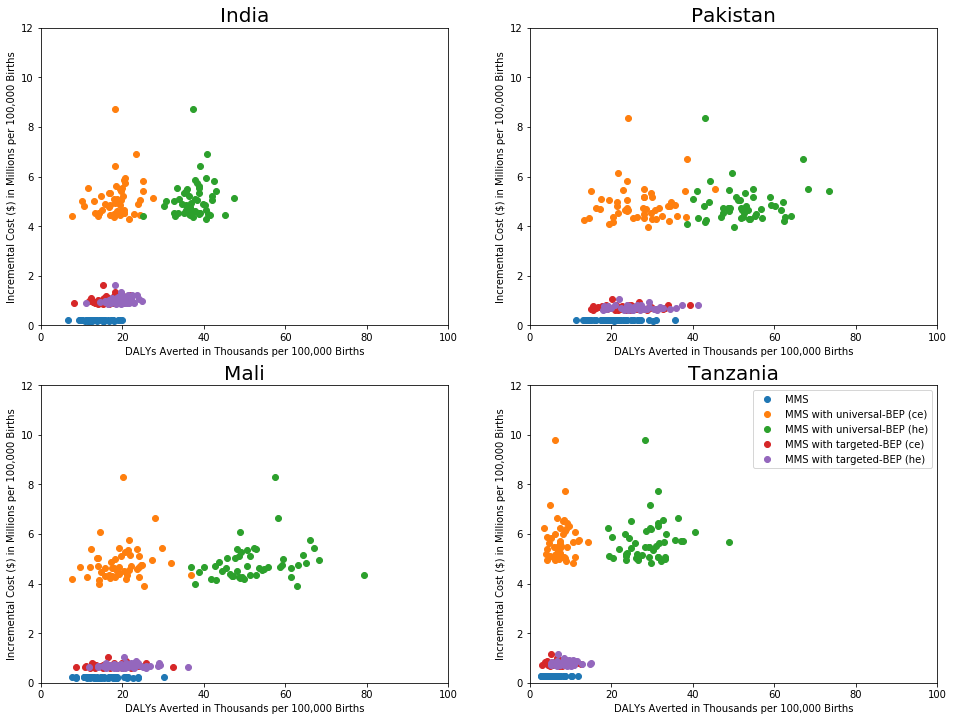

In [25]:
fig, axs = plt.subplots(2,2)

india = master_draws.where(master_draws['location'] == 'India').dropna()
pakistan = master_draws.where(master_draws['location'] == 'Pakistan').dropna()
mali = master_draws.where(master_draws['location'] == 'Mali').dropna()
tanzania = master_draws.where(master_draws['location'] == 'Tanzania').dropna()

scenarios_names = ['MMS',
                   'MMS with universal-BEP (ce)', 
                   'MMS with universal-BEP (he)',
                   'MMS with targeted-BEP (ce)',
                   'MMS with targeted-BEP (he)']


#------------------------INDIA---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[0,0].scatter(india['dalys_averted_mmn']*(-1)/1_000, india['cost_diff_mmn']/1_000_000)

#bep ce_universal
axs[0,0].scatter(india['dalys_averted_bep_ce_universal']*(-1)/1_000, india['cost_diff_bep_ce_universal']/1_000_000)

#bep hd_universal
axs[0,0].scatter(india['dalys_averted_bep_hd_universal']*(-1)/1_000, india['cost_diff_bep_hd_universal']/1_000_000)

#bep ce_targeted
axs[0,0].scatter(india['dalys_averted_bep_ce_targeted']*(-1)/1_000, india['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_targeted
axs[0,0].scatter(india['dalys_averted_bep_hd_targeted']*(-1)/1_000, india['cost_diff_bep_hd_targeted']/1_000_000)

#cost bounds for BEP
# axs[0,0].scatter(india['dalys_averted_bep_ce_universal']*(-1)/1_000, india['cost_diff_bep_ce_universal_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_ce_universal']*(-1)/1_000, india['cost_diff_bep_ce_universal_high']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_ce_targeted']*(-1)/1_000, india['cost_diff_bep_ce_targeted_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_ce_targeted']*(-1)/1_000, india['cost_diff_bep_ce_targeted_high']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_universal']*(-1)/1_000, india['cost_diff_bep_hd_universal_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_universal']*(-1)/1_000, india['cost_diff_bep_hd_universal_high']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_targeted']*(-1)/1_000, india['cost_diff_bep_hd_targeted_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_targeted']*(-1)/1_000, india['cost_diff_bep_hd_targeted_high']/1_000_000,marker='_',c='grey')

axs[0,0].set_title('India',fontsize=20)
axs[0,0].set_xlim(0,100)
axs[0,0].set_ylim(0,12)

#------------------------PAKISTAN---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[0,1].scatter(pakistan['dalys_averted_mmn']*(-1)/1_000, pakistan['cost_diff_mmn']/1_000_000)

#bep ce_universal
axs[0,1].scatter(pakistan['dalys_averted_bep_ce_universal']*(-1)/1_000, pakistan['cost_diff_bep_ce_universal']/1_000_000)

#bep hd_universal
axs[0,1].scatter(pakistan['dalys_averted_bep_hd_universal']*(-1)/1_000, pakistan['cost_diff_bep_hd_universal']/1_000_000)

#bep ce_targeted
axs[0,1].scatter(pakistan['dalys_averted_bep_ce_targeted']*(-1)/1_000, pakistan['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_targeted
axs[0,1].scatter(pakistan['dalys_averted_bep_hd_targeted']*(-1)/1_000, pakistan['cost_diff_bep_hd_targeted']/1_000_000)


axs[0,1].set_title('Pakistan',fontsize=20)
axs[0,1].set_xlim(0,100)
axs[0,1].set_ylim(0,12)


#------------------------MALI---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[1,0].scatter(mali['dalys_averted_mmn']*(-1)/1_000, mali['cost_diff_mmn']/1_000_000)

#bep ce_universal
axs[1,0].scatter(mali['dalys_averted_bep_ce_universal']*(-1)/1_000, mali['cost_diff_bep_ce_universal']/1_000_000)

#bep hd_universal
axs[1,0].scatter(mali['dalys_averted_bep_hd_universal']*(-1)/1_000, mali['cost_diff_bep_hd_universal']/1_000_000)

#bep ce_targeted
axs[1,0].scatter(mali['dalys_averted_bep_ce_targeted']*(-1)/1_000, mali['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_targeted
axs[1,0].scatter(mali['dalys_averted_bep_hd_targeted']*(-1)/1_000, mali['cost_diff_bep_hd_targeted']/1_000_000)

axs[1,0].set_title('Mali',fontsize=20)
axs[1,0].set_xlim(0,100)
axs[1,0].set_ylim(0,12)


#------------------------TANZANIA---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[1,1].scatter(tanzania['dalys_averted_mmn']*(-1)/1_000, tanzania['cost_diff_mmn']/1_000_000)

#bep ce_universal
axs[1,1].scatter(tanzania['dalys_averted_bep_ce_universal']*(-1)/1_000, tanzania['cost_diff_bep_ce_universal']/1_000_000)

#bep hd_universal
axs[1,1].scatter(tanzania['dalys_averted_bep_hd_universal']*(-1)/1_000, tanzania['cost_diff_bep_hd_universal']/1_000_000)

#bep ce_targeted
axs[1,1].scatter(tanzania['dalys_averted_bep_ce_targeted']*(-1)/1_000, tanzania['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_targeted
axs[1,1].scatter(tanzania['dalys_averted_bep_hd_targeted']*(-1)/1_000, tanzania['cost_diff_bep_hd_targeted']/1_000_000)

axs[1,1].set_title('Tanzania',fontsize=20)
axs[1,1].set_xlim(0,100)
axs[1,1].set_ylim(0,12)


for ax in axs.flat:
    ax.set(xlabel='DALYs Averted in Thousands per 100,000 Births', 
           ylabel='Incremental Cost ($) in Millions per 100,000 Births')
    #ax.label_outer()

plt.legend(scenarios_names, prop={'size': 10})
#plt.suptitle('DALYs Averted Versus Incremental Cost Relative to Baseline for 100,000 Births',x=1.1,y=2.6,fontsize=20)
plt.subplots_adjust(right=2.2, top=2.4)


# --------------------------------------
# COST DIFFERENCE ONLY
# --------------------------------------

In [15]:
india = master_draws.where(master_draws['location'] == 'India').dropna()
india.head()

,input_draw,dalys_baseline,person_time,total_population_baseline,bep_population_baseline,ifa_population_baseline,mmn_population_baseline,untreated_population_baseline,location_baseline,cost,...,icer_bep_hd_universal_low,icer_bep_hd_universal_high,icer_bep_hd_targeted,icer_bep_hd_targeted_low,icer_bep_hd_targeted_high,icer_bep_ce_universal_rel_to_mmn,icer_bep_ce_targeted_rel_to_mmn,icer_bep_hd_universal_rel_to_mmn,icer_bep_hd_targeted_rel_to_mmn,location
0,3.0,322427.572855,193360.747433,100000.0,0.0,35192.0,0.0,64808.0,India,94666.48,...,-117.906819,-268.779156,-55.996610,-58.520447,-58.520447,-1128.869234,-265.954540,-190.681682,-161.639683,India
1,21.0,310214.519550,193675.227926,100000.0,0.0,39783.0,0.0,60217.0,India,107016.27,...,-125.247688,-286.010524,-51.120347,-50.043542,-50.043542,-2426.295346,-546.740842,-284.260654,-225.517939,India
2,29.0,346508.977417,192982.280630,100000.0,0.0,36533.0,0.0,63467.0,India,98273.77,...,-105.826655,-241.356135,-58.377158,-50.778165,-50.778165,-659.222849,-229.870202,-199.451287,-136.169752,India
3,55.0,323656.884168,193378.187543,100000.0,0.0,32773.0,0.0,67227.0,India,88159.37,...,-121.777027,-277.391384,-57.112642,-54.087661,-54.087661,-1267.023924,-272.366539,-227.164542,-147.638716,India
4,78.0,311126.782565,193657.957563,100000.0,0.0,32504.0,0.0,67496.0,India,87435.76,...,-111.387265,-253.699186,-54.250333,-48.076767,-48.076767,-1539.529784,-574.156095,-260.616441,-192.282386,India


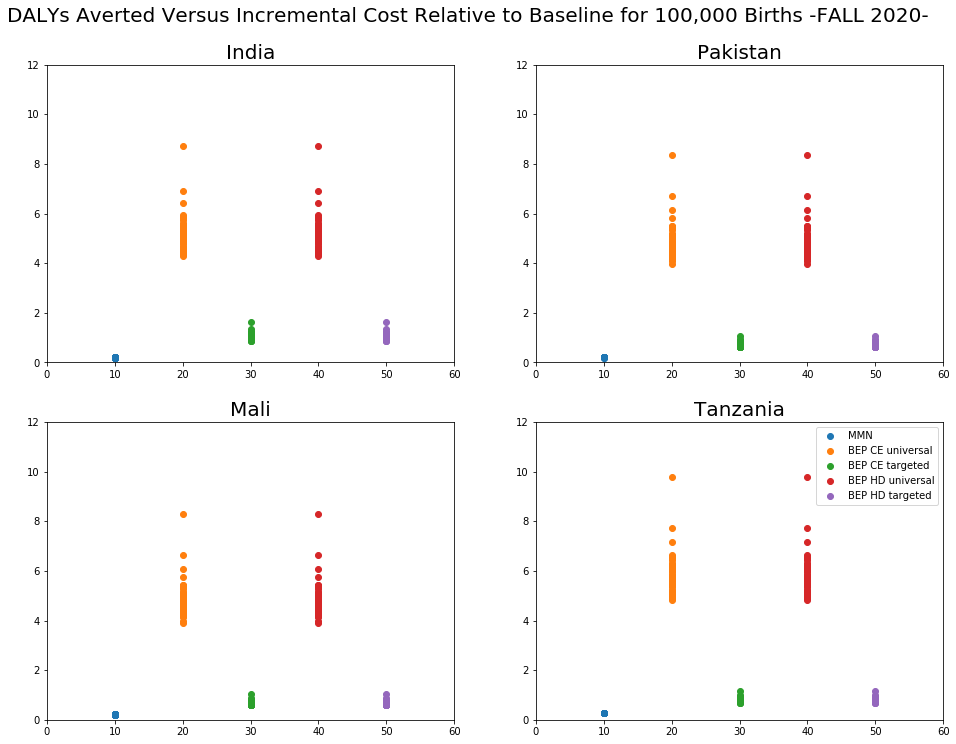

In [16]:
fig, axs = plt.subplots(2,2)

india = master_draws.where(master_draws['location'] == 'India').dropna()
india['10'] = 10
india['20'] = 20
india['30'] = 30
india['40'] = 40
india['50'] = 50

pakistan = master_draws.where(master_draws['location'] == 'Pakistan').dropna()
pakistan['10'] = 10
pakistan['20'] = 20
pakistan['30'] = 30
pakistan['40'] = 40
pakistan['50'] = 50

mali = master_draws.where(master_draws['location'] == 'Mali').dropna()
mali['10'] = 10
mali['20'] = 20
mali['30'] = 30
mali['40'] = 40
mali['50'] = 50

tanzania = master_draws.where(master_draws['location'] == 'Tanzania').dropna()
tanzania['10'] = 10
tanzania['20'] = 20
tanzania['30'] = 30
tanzania['40'] = 40
tanzania['50'] = 50

#------------------------INDIA---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[0,0].scatter(india['10'], india['cost_diff_mmn']/1_000_000)

#bep ce_universal
axs[0,0].scatter(india['20'], india['cost_diff_bep_ce_universal']/1_000_000)

#bep ce_targeted
axs[0,0].scatter(india['30'], india['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_universal

axs[0,0].scatter(india['40'], india['cost_diff_bep_hd_universal']/1_000_000)

#bep hd_targeted

axs[0,0].scatter(india['50'], india['cost_diff_bep_hd_targeted']/1_000_000)

#cost bounds for BEP
# axs[0,0].scatter(india['dalys_averted_bep_ce_universal']*(-1)/1_000, india['cost_diff_bep_ce_universal_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_ce_universal']*(-1)/1_000, india['cost_diff_bep_ce_universal_high']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_ce_targeted']*(-1)/1_000, india['cost_diff_bep_ce_targeted_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_ce_targeted']*(-1)/1_000, india['cost_diff_bep_ce_targeted_high']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_universal']*(-1)/1_000, india['cost_diff_bep_hd_universal_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_universal']*(-1)/1_000, india['cost_diff_bep_hd_universal_high']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_targeted']*(-1)/1_000, india['cost_diff_bep_hd_targeted_low']/1_000_000,marker='_',c='grey')
# axs[0,0].scatter(india['dalys_averted_bep_hd_targeted']*(-1)/1_000, india['cost_diff_bep_hd_targeted_high']/1_000_000,marker='_',c='grey')

axs[0,0].set_title('India',fontsize=20)
axs[0,0].set_xlim(0,60)
axs[0,0].set_ylim(0,12)

#------------------------PAKISTAN---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[0,1].scatter(pakistan['10'], pakistan['cost_diff_mmn']/1_000_000)
#bep ce_universal
axs[0,1].scatter(pakistan['20'], pakistan['cost_diff_bep_ce_universal']/1_000_000)
#bep ce_targeted
axs[0,1].scatter(pakistan['30'], pakistan['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_universal
#axs[0,1].scatter(pakistan['dalys_averted_bep_hd_universal_i']*(-1)/1_000, pakistan['cost_diff_bep_hd_universal_i']/1_000_000)
#axs[0,1].scatter(pakistan['dalys_averted_bep_hd_universal_ii']*(-1)/1_000, pakistan['cost_diff_bep_hd_universal_ii']/1_000_000)
axs[0,1].scatter(pakistan['40'], pakistan['cost_diff_bep_hd_universal']/1_000_000)

#bep hd_targeted
#axs[0,1].scatter(pakistan['dalys_averted_bep_hd_targeted_i']*(-1)/1_000, pakistan['cost_diff_bep_hd_targeted_i']/1_000_000)
#axs[0,1].scatter(pakistan['dalys_averted_bep_hd_targeted_ii']*(-1)/1_000, pakistan['cost_diff_bep_hd_targeted_ii']/1_000_000)
axs[0,1].scatter(pakistan['50'], pakistan['cost_diff_bep_hd_targeted']/1_000_000)

#BEP cost bounds
# axs[0,1].scatter(pakistan['dalys_averted_bep_ce_universal']*(-1)/1_000, pakistan['cost_diff_bep_ce_universal_low']/1_000_000,marker='_',c='grey')
# axs[0,1].scatter(pakistan['dalys_averted_bep_ce_universal']*(-1)/1_000, pakistan['cost_diff_bep_ce_universal_high']/1_000_000,marker='_',c='grey')
# axs[0,1].scatter(pakistan['dalys_averted_bep_ce_targeted']*(-1)/1_000, pakistan['cost_diff_bep_ce_targeted_low']/1_000_000,marker='_',c='grey')
# axs[0,1].scatter(pakistan['dalys_averted_bep_ce_targeted']*(-1)/1_000, pakistan['cost_diff_bep_ce_targeted_high']/1_000_000,marker='_',c='grey')
# axs[0,1].scatter(pakistan['dalys_averted_bep_hd_universal']*(-1)/1_000, pakistan['cost_diff_bep_hd_universal_low']/1_000_000,marker='_',c='grey')
# axs[0,1].scatter(pakistan['dalys_averted_bep_hd_universal']*(-1)/1_000, pakistan['cost_diff_bep_hd_universal_high']/1_000_000,marker='_',c='grey')
# axs[0,1].scatter(pakistan['dalys_averted_bep_hd_targeted']*(-1)/1_000, pakistan['cost_diff_bep_hd_targeted_low']/1_000_000,marker='_',c='grey')
# axs[0,1].scatter(pakistan['dalys_averted_bep_hd_targeted']*(-1)/1_000, pakistan['cost_diff_bep_hd_targeted_high']/1_000_000,marker='_',c='grey')

axs[0,1].set_title('Pakistan',fontsize=20)
axs[0,1].set_xlim(0,60)
axs[0,1].set_ylim(0,12)


#------------------------MALI---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[1,0].scatter(mali['10'], mali['cost_diff_mmn']/1_000_000)

#bep ce_universal
axs[1,0].scatter(mali['20'], mali['cost_diff_bep_ce_universal']/1_000_000)

#bep ce_targeted
axs[1,0].scatter(mali['30'], mali['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_universal
axs[1,0].scatter(mali['40'], mali['cost_diff_bep_hd_universal']/1_000_000)

#bep hd_targeted
axs[1,0].scatter(mali['50'], mali['cost_diff_bep_hd_targeted']/1_000_000)

#BEP COST BOUNDS
# axs[1,0].scatter(mali['dalys_averted_bep_ce_universal']*(-1)/1_000, mali['cost_diff_bep_ce_universal_low']/1_000_000,marker='_',c='grey')
# axs[1,0].scatter(mali['dalys_averted_bep_ce_universal']*(-1)/1_000, mali['cost_diff_bep_ce_universal_high']/1_000_000,marker='_',c='grey')
# axs[1,0].scatter(mali['dalys_averted_bep_ce_targeted']*(-1)/1_000, mali['cost_diff_bep_ce_targeted_low']/1_000_000,marker='_',c='grey')
# axs[1,0].scatter(mali['dalys_averted_bep_ce_targeted']*(-1)/1_000, mali['cost_diff_bep_ce_targeted_high']/1_000_000,marker='_',c='grey')
# axs[1,0].scatter(mali['dalys_averted_bep_hd_universal']*(-1)/1_000, mali['cost_diff_bep_hd_universal_low']/1_000_000,marker='_',c='grey')
# axs[1,0].scatter(mali['dalys_averted_bep_hd_universal']*(-1)/1_000, mali['cost_diff_bep_hd_universal_high']/1_000_000,marker='_',c='grey')
# axs[1,0].scatter(mali['dalys_averted_bep_hd_targeted']*(-1)/1_000, mali['cost_diff_bep_hd_targeted_low']/1_000_000,marker='_',c='grey')
# axs[1,0].scatter(mali['dalys_averted_bep_hd_targeted']*(-1)/1_000, mali['cost_diff_bep_hd_targeted_high']/1_000_000,marker='_',c='grey')

axs[1,0].set_title('Mali',fontsize=20)
axs[1,0].set_xlim(0,60)
axs[1,0].set_ylim(0,12)


#------------------------TANZANIA---------------------------------------------------------------------------------------------------------------------------------------#

#mmn 
axs[1,1].scatter(tanzania['10'], tanzania['cost_diff_mmn']/1_000_000)
#bep ce_universal
axs[1,1].scatter(tanzania['20'], tanzania['cost_diff_bep_ce_universal']/1_000_000)
#bep ce_targeted
axs[1,1].scatter(tanzania['30'], tanzania['cost_diff_bep_ce_targeted']/1_000_000)

#bep hd_universal
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_universal_i']*(-1)/1_000, tanzania['cost_diff_bep_hd_universal_i']/1_000_000)
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_universal_ii']*(-1)/1_000, tanzania['cost_diff_bep_hd_universal_ii']/1_000_000)
axs[1,1].scatter(tanzania['40'], tanzania['cost_diff_bep_hd_universal']/1_000_000)

#bep hd_targeted
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_targeted_i']*(-1)/1_000, tanzania['cost_diff_bep_hd_targeted_i']/1_000_000)
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_targeted_ii']*(-1)/1_000, tanzania['cost_diff_bep_hd_targeted_ii']/1_000_000)
axs[1,1].scatter(tanzania['50'], tanzania['cost_diff_bep_hd_targeted']/1_000_000)

#BEP COST BOUNDS

#axs[1,1].scatter(tanzania['dalys_averted_bep_ce_universal']*(-1)/1_000, tanzania['cost_diff_bep_ce_universal_low']/1_000_000,marker='_',c='grey')
#axs[1,1].scatter(tanzania['dalys_averted_bep_ce_universal']*(-1)/1_000, tanzania['cost_diff_bep_ce_universal_high']/1_000_000,marker='_',c='grey')
#axs[1,1].scatter(tanzania['dalys_averted_bep_ce_targeted']*(-1)/1_000, tanzania['cost_diff_bep_ce_targeted_low']/1_000_000,marker='_',c='grey')
#axs[1,1].scatter(tanzania['dalys_averted_bep_ce_targeted']*(-1)/1_000, tanzania['cost_diff_bep_ce_targeted_high']/1_000_000,marker='_',c='grey')
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_universal']*(-1)/1_000, tanzania['cost_diff_bep_hd_universal_low']/1_000_000,marker='_',c='grey')
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_universal']*(-1)/1_000, tanzania['cost_diff_bep_hd_universal_high']/1_000_000,marker='_',c='grey')
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_targeted']*(-1)/1_000, tanzania['cost_diff_bep_hd_targeted_low']/1_000_000,marker='_',c='grey')
#axs[1,1].scatter(tanzania['dalys_averted_bep_hd_targeted']*(-1)/1_000, tanzania['cost_diff_bep_hd_targeted_high']/1_000_000,marker='_',c='grey')

axs[1,1].set_title('Tanzania',fontsize=20)
axs[1,1].set_xlim(0,60)
axs[1,1].set_ylim(0,12)

plt.legend(['MMN','BEP CE universal','BEP CE targeted', 'BEP HD universal','BEP HD targeted'], prop={'size': 10}, loc=1)
plt.suptitle('DALYs Averted Versus Incremental Cost Relative to Baseline for 100,000 Births -FALL 2020-',x=1.1,y=2.6,fontsize=20)
plt.subplots_adjust(right=2.2, top=2.4)


# ==================

# DALYs BAR PLOTS

# ==================




# ALL SCENARIOs

color coding and scenario order (https://matplotlib.org/3.1.0/gallery/color/named_colors.html): 

- 1) baseline = grey
- 2) mmn = blue

- 3) BEP_ce_universal = mediumvioletred
- 4) BEP_hd_universal_i = orange
- 5) BEP_hd_universal_ii = darkorange
- 6) BEP_hd_universal_iii = tab:pink


- 7) BEP_ce_targeted = olivedrab
- 8) BEP_hd_targeted_i = cornflowerblue
- 9) BEP_hd_targeted_ii = royalblue
- 10) BEP_hd_targeted_iii = mediumseagreen

[0    325.282946
0    453.251477
0    728.510958
0    410.431148
Name: mean, dtype: float64, 38    311.635600
38    432.392331
38    712.967064
38    404.526767
Name: mean, dtype: float64, 45    306.928198
45    426.470537
45    708.928784
45    402.925302
Name: mean, dtype: float64, 17    287.755801
17    400.817104
17    676.142426
17    381.379037
Name: mean, dtype: float64, 27    308.875151
27    429.589634
27    710.992658
27    403.646021
Name: mean, dtype: float64, 7    305.981567
7    427.072216
7    707.751594
7    401.559765
Name: mean, dtype: float64]


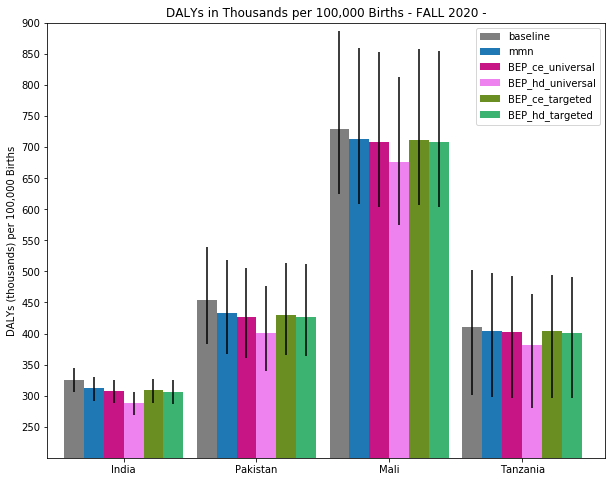

In [17]:
#DALYS all scenarios

data = master_avg #.where(master_avg['malnourishment_category'] == 'all').dropna()

# bar width
barWidth = 0.15
w = 0.15

# bar heights

#baseline 1
baseline = master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() / 1_000
baseline_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000
baseline_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000

#mmn 2
mmn = master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna()/ 1_000
mmn_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000
mmn_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000


#bep_ce_universal 3
bep_ce_universal = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_ce_universal').dropna() /1_000
bep_ce_universal_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_ce_universal').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_ce_universal').dropna())/ 1_000
bep_ce_universal_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_ce_universal').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_ce_universal').dropna())/1_000

#bep_hd_universal 4
bep_hd_universal = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna() /1_000
bep_hd_universal_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna())/ 1_000
bep_hd_universal_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna())/1_000

#bep_ce_targeted 5
bep_ce_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_ce_targeted').dropna()/1_000
bep_ce_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_ce_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_ce_targeted').dropna())/1_000
bep_ce_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_ce_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_ce_targeted').dropna())/1_000

#bep_hd_targeted 6
bep_hd_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna()/1_000
bep_hd_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna())/1_000
bep_hd_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna())/1_000



# x-values bar positions
# baseline_x         = [6*element + w*1 for element in range (4)] 
# mmn_x              = [6*element + w*2 for element in range (4)]
# bep_ce_universal_x = [6*element + w*3 for element in range (4)] 
# bep_ce_targeted_x  = [6*element + w*4 for element in range (4)]
# bep_hd_universal_x = [6*element + w*5 for element in range (4)]
# bep_hd_targeted_x  = [6*element + w*6 for element in range (4)]

baseline_x = np.arange(len(baseline)) 
mmn_x = [x + barWidth for x in baseline_x]
bep_ce_universal_x = [x + barWidth for x in mmn_x]
bep_hd_universal_x = [x + barWidth for x in bep_ce_universal_x]
bep_ce_targeted_x = [x + barWidth for x in bep_hd_universal_x]
bep_hd_targeted_x = [x + barWidth for x in bep_ce_targeted_x]

# plot
plt.figure(figsize=(10,8))

#---- note: yerrs should be lower, upper

# baseline
plt.bar(baseline_x, baseline, yerr=[baseline_lower, baseline_upper], width=barWidth, color='tab:grey', label='baseline')

#mmn
plt.bar(mmn_x, mmn, yerr=[mmn_lower, mmn_upper], width=barWidth, color='tab:blue',label='mmn')

#unicersal ce and hd
plt.bar(bep_ce_universal_x, bep_ce_universal, yerr=[bep_ce_universal_lower, bep_ce_universal_upper], width=barWidth, color='mediumvioletred', label='BEP_ce_universal')
plt.bar(bep_hd_universal_x, bep_hd_universal, yerr=[bep_hd_universal_lower, bep_hd_universal_upper], width=barWidth, color='violet', label='BEP_hd_universal')

#targeted ce and hd
plt.bar(bep_ce_targeted_x, bep_ce_targeted, yerr=[bep_ce_targeted_lower, bep_ce_targeted_upper], width=barWidth, color='olivedrab', label='BEP_ce_targeted')
plt.bar(bep_hd_targeted_x, bep_hd_targeted, yerr=[bep_hd_targeted_lower, bep_hd_targeted_upper], width=barWidth, color='mediumseagreen', label='BEP_hd_targeted')

plt.xticks([r + 2.5*barWidth for r in range(len(baseline))], master_avg['location'].where(master_avg['index'] == 'dalys_baseline').dropna())

plt.axis([-0.2 , 4 , 200, 900])
plt.yticks([250,300,350,400,450,500,550,600,650,700,750,800,850,900])
plt.ylabel('DALYs (thousands) per 100,000 Births')
plt.title('DALYs in Thousands per 100,000 Births - FALL 2020 -')

y = [baseline, mmn, bep_ce_universal, bep_hd_universal, bep_ce_targeted, bep_hd_targeted]
print(y)

plt.legend()
#plt.savefig('fig_DALYS')


# scenarios baseline, mmn, bep_hd_universal, bep_hd_targeted




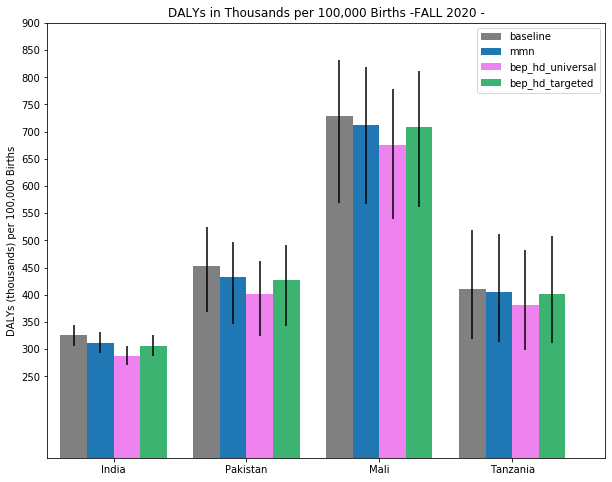

In [18]:
#baseline, mmn, bep_hd_universal_iii, bep_hd_targeted_iii

data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()

# bar width
barWidth = 0.2

# bar heights
baseline = master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() / 1_000
baseline_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000
baseline_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000

mmn = master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna()/ 1_000
mmn_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000
mmn_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000

bep = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna() /1_000
bep_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna())/ 1_000
bep_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_hd_universal').dropna())/1_000

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna()/1_000
bep_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna())/1_000
bep_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_hd_targeted').dropna())/1_000

# bar positions
baseline_x = np.arange(len(baseline)) 
mmn_x = [x + barWidth for x in baseline_x]
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.figure(figsize=(10,8))
plt.bar(baseline_x, baseline, yerr=[baseline_upper, baseline_lower], width=barWidth, color='grey', label='baseline')
plt.bar(mmn_x, mmn, yerr=[mmn_upper, mmn_lower], width=barWidth, color='tab:blue', label='mmn')
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth, color='violet', label='bep_hd_universal')
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth, color ='mediumseagreen',label='bep_hd_targeted')

#
plt.xticks([r + 1.5*barWidth for r in range(len(baseline))], master_avg['location'].where(master_avg['index'] == 'dalys_baseline').dropna())
plt.axis([-0.2 , 4 , 100, 900])
plt.yticks([250,300,350,400,450,500,550,600,650,700,750,800,850,900])
plt.ylabel('DALYs (thousands) per 100,000 Births')
plt.title('DALYs in Thousands per 100,000 Births -FALL 2020 -')
plt.legend(loc=1)


# -------------------------
# DALYs averted 
# -------------------------

[0    325.282946
0    453.251477
0    728.510958
0    410.431148
Name: mean, dtype: float64, 55    13.647345
55    20.859146
55    15.543894
55     5.904382
Name: mean, dtype: float64, 57    18.354748
57    26.780940
57    19.582175
57     7.505847
Name: mean, dtype: float64, 66    37.527145
66    52.434373
66    52.368533
66    29.052112
Name: mean, dtype: float64, 62    16.407795
62    23.661843
62    17.518300
62     6.785128
Name: mean, dtype: float64, 71    19.301379
71    26.179261
71    20.759364
71     8.871384
Name: mean, dtype: float64]


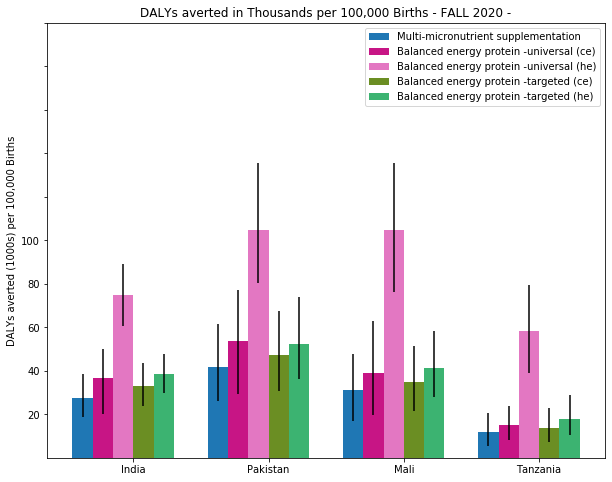

In [19]:
#DALYS AVERTED all scenarios

data = master_avg #.where(master_avg['malnourishment_category'] == 'all').dropna()

# bar width
barWidth = 0.15
w = 0.15

# bar heights

#mmn 1
mmn = master_avg['mean'].where(master_avg['index'] == 'dalys_averted_mmn').dropna()*(-1)/ 1_000
mmn_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_averted_mmn').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_averted_mmn').dropna())*(-1)/ 1_000
mmn_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_averted_mmn').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_averted_mmn').dropna())*(-1)/ 1_000


#bep_ce_universal 3
bep_ce_universal = master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_ce_universal').dropna() *(-1)/1_000
bep_ce_universal_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_averted_bep_ce_universal').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_ce_universal').dropna())*(-1)/ 1_000
bep_ce_universal_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_ce_universal').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_averted_bep_ce_universal').dropna())*(-1)/1_000

#bep_hd_universal 4
bep_hd_universal = master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_hd_universal').dropna() *(-1)/1_000
bep_hd_universal_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_averted_bep_hd_universal').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_hd_universal').dropna())*(-1)/ 1_000
bep_hd_universal_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_hd_universal').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_averted_bep_hd_universal').dropna())*(-1)/1_000

#bep_ce_targeted 5
bep_ce_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_ce_targeted').dropna()*(-1)/1_000
bep_ce_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_averted_bep_ce_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_ce_targeted').dropna())*(-1)/1_000
bep_ce_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_ce_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_averted_bep_ce_targeted').dropna())*(-1)/1_000

#bep_hd_targeted 6
bep_hd_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_hd_targeted').dropna()*(-1)/1_000
bep_hd_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_averted_bep_hd_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_hd_targeted').dropna())*(-1)/1_000
bep_hd_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_averted_bep_hd_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_averted_bep_hd_targeted').dropna())*(-1)/1_000


# x-values bar positions
# baseline_x         = [6*element + w*1 for element in range (4)] 
# mmn_x              = [6*element + w*2 for element in range (4)]
# bep_ce_universal_x = [6*element + w*3 for element in range (4)] 
# bep_ce_targeted_x  = [6*element + w*4 for element in range (4)]
# bep_hd_universal_x = [6*element + w*5 for element in range (4)]
# bep_hd_targeted_x  = [6*element + w*6 for element in range (4)]

mmn_x = np.arange(len(mmn)) 
bep_ce_universal_x = [x + barWidth for x in mmn_x]
bep_hd_universal_x = [x + barWidth for x in bep_ce_universal_x]
bep_ce_targeted_x  = [x + barWidth for x in bep_hd_universal_x]
bep_hd_targeted_x  = [x + barWidth for x in bep_ce_targeted_x]

# plot
plt.figure(figsize=(10,8))

#---- note: yerrs should be lower, upper

#mmn
plt.bar(mmn_x, mmn, yerr=[mmn_lower, mmn_upper], width=barWidth, color='tab:blue',label='Multi-micronutrient supplementation')

# universal ce and hd
plt.bar(bep_ce_universal_x, bep_ce_universal, yerr=[bep_ce_universal_lower, bep_ce_universal_upper], width=barWidth, color='mediumvioletred', label='Balanced energy protein -universal (ce)')

plt.bar(bep_hd_universal_x, bep_hd_universal, yerr=[bep_hd_universal_lower, bep_hd_universal_upper], width=barWidth, color='tab:pink', label='Balanced energy protein -universal (he)')

#targeted ce and hd
plt.bar(bep_ce_targeted_x, bep_ce_targeted, yerr=[bep_ce_targeted_lower, bep_ce_targeted_upper], width=barWidth, color='olivedrab', label='Balanced energy protein -targeted (ce)')
plt.bar(bep_hd_targeted_x, bep_hd_targeted, yerr=[bep_hd_targeted_lower, bep_hd_targeted_upper], width=barWidth, color='mediumseagreen', label='Balanced energy protein -targeted (he)')

plt.xticks([r + 2.5*barWidth for r in range(len(baseline))], master_avg['location'].where(master_avg['index'] == 'dalys_baseline').dropna())

#plt.axis([-0.2 , 4 , 200, 900])
plt.yticks([10,20,30,40,50,60,70,80,90,100],[20,40,60,80,100])
plt.ylabel('DALYs averted (1000s) per 100,000 Births')
plt.title('DALYs averted in Thousands per 100,000 Births - FALL 2020 -')

y = [baseline, mmn, bep_ce_universal, bep_hd_universal, bep_ce_targeted, bep_hd_targeted]
print(y)

plt.legend()
#plt.savefig('fig_DALYS')

In [20]:
print(mmn)

55    13.647345
55    20.859146
55    15.543894
55     5.904382
Name: mean, dtype: float64


# ==================================================================================================================

# ICER BAR PLOTS

# ==================================================================================================================

# scenarios: mmn, bep_ce_universal, bep_universal_hd, bep_ce_targeted, bep_targeted_hd

[83    15.482052
83    10.892638
83    14.972259
83    51.194757
Name: mean, dtype: float64, 84    292.206456
84    195.598519
84    267.578805
84    833.296038
Name: mean, dtype: float64, 90    136.753816
90     95.071727
90     94.243195
90    202.907065
Name: mean, dtype: float64, 87     64.302707
87     31.648756
87     42.063506
87    126.036701
Name: mean, dtype: float64, 93    54.121340
93    28.353207
93    34.793531
93    94.070160
Name: mean, dtype: float64]
[83    -5.135728
83    -4.298037
83    -6.180166
83   -25.801577
dtype: float64, array([-103.30309484,  -74.12621253, -116.08758064, -376.90720807]), 66    -7.284997
66   -12.197203
66   -14.281217
66    -9.586276
dtype: float64, array([-18.3255592 , -10.74414994, -14.97249502, -56.40519814]), 71   -4.446710
71   -7.977693
71   -6.757087
71   -3.552185
dtype: float64]
[83    -5.979893
83    -5.512924
83    -9.925257
83   -46.774437
dtype: float64, array([-204.34901749, -147.32469594, -206.73337853, -725.80648838]), 66    

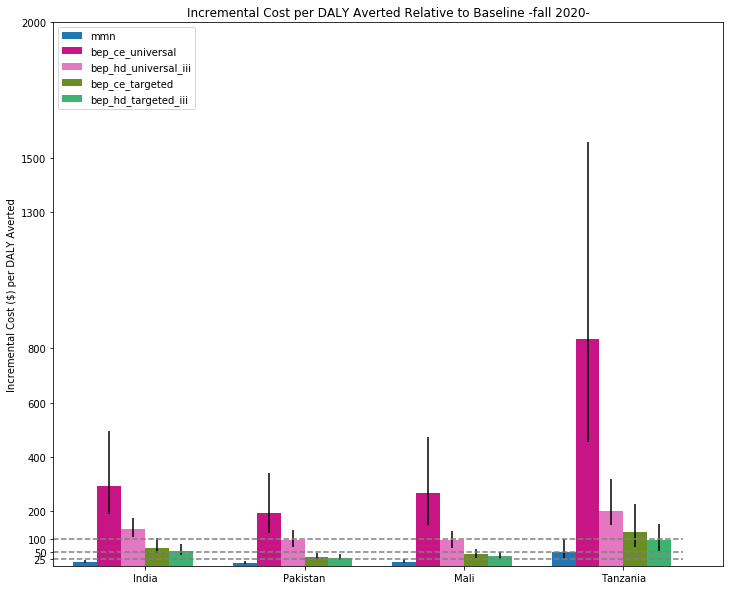

In [21]:
#LINEAR

data = master_avg #.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.15

# bar heights (y-axis) 
mmn = master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_upper =  master_avg['max'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)

bep_ce_universal = master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna()*(-1)
bep_ce_universal_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1))
bep_ce_universal_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1))

bep_hd_universal_iii = master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna()*(-1)
bep_hd_universal_iii_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1))
bep_hd_universal_iii_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1))

bep_ce_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna()*(-1)
bep_ce_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1))
bep_ce_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1))

bep_hd_targeted_iii = master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna()*(-1)
bep_hd_targeted_iii_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1))
bep_hd_targeted_iii_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1))


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# bar positions (for x-axis)
mmn_x = np.arange(len(mmn)) 
bep_ce_universal_x = [x + barWidth for x in mmn_x]
bep_hd_universal_iii_x = [x + barWidth for x in bep_ce_universal_x]
bep_ce_targeted_x = [x + barWidth for x in bep_hd_universal_iii_x ]
bep_hd_targeted_iii_x = [x + barWidth for x in bep_ce_targeted_x]

# plot

plt.figure(figsize=(12,10))
plt.bar(mmn_x, mmn, yerr=[mmn_lower, mmn_upper], width=barWidth, label = 'mmn')
plt.bar(bep_ce_universal_x, bep_ce_universal, yerr=[bep_ce_universal_lower, bep_ce_universal_upper], width=barWidth, label = 'bep_ce_universal', color = 'mediumvioletred')
plt.bar(bep_hd_universal_iii_x, bep_hd_universal_iii, yerr=[bep_hd_universal_iii_lower, bep_hd_universal_iii_upper], width=barWidth, label = 'bep_hd_universal_iii', color = 'tab:pink')
plt.bar(bep_ce_targeted_x, bep_ce_targeted, yerr=[bep_ce_targeted_lower, bep_ce_targeted_upper], width=barWidth, label = 'bep_ce_targeted', color = 'olivedrab')
plt.bar(bep_hd_targeted_iii_x, bep_hd_targeted_iii, yerr=[bep_hd_targeted_iii_lower, bep_hd_targeted_iii_upper], width=barWidth, label = 'bep_hd_targeted_iii', color = 'mediumseagreen')

plt.legend(loc='upper left')

threshold = 100
threshold2 = 50
threshold3 = 25
plt.plot([-0.25,len(mmn)-.25], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold3, threshold3],'k--', c='gray')

#
plt.axis([-0.2 , 4 , 0, 1500])
plt.yticks([25,50,100,200,400,600,800,1300, 1500, 2000])
#plt.yscale('log') 
plt.xticks([r + 2.5*barWidth for r in range(len(mmn))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to Baseline -fall 2020-')
#plt.savefig('fig_ICERS_baseline')

y = [mmn, bep_ce_universal, bep_hd_universal_iii, bep_ce_targeted, bep_hd_targeted_iii]
y_lower = [mmn_lower, bep_ce_universal_lower, bep_hd_universal_lower, bep_ce_targeted_lower, bep_hd_targeted_lower]
y_upper = [mmn_upper, bep_ce_universal_upper, bep_hd_universal_upper, bep_ce_targeted_upper, bep_hd_targeted_upper]

print(y)
print(y_upper)
print(y_lower)

In [22]:
mmn = master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
np.log(mmn)

83    2.739681
83    2.388087
83    2.706199
83    3.935637
Name: mean, dtype: float64

/share/code/nicoly/miniconda/envs/gates_bep/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


[83    15.482052
83    10.892638
83    14.972259
83    51.194757
Name: mean, dtype: float64, 84    292.206456
84    195.598519
84    267.578805
84    833.296038
Name: mean, dtype: float64, 90    136.753816
90     95.071727
90     94.243195
90    202.907065
Name: mean, dtype: float64, 87     64.302707
87     31.648756
87     42.063506
87    126.036701
Name: mean, dtype: float64, 93    54.121340
93    28.353207
93    34.793531
93    94.070160
Name: mean, dtype: float64]


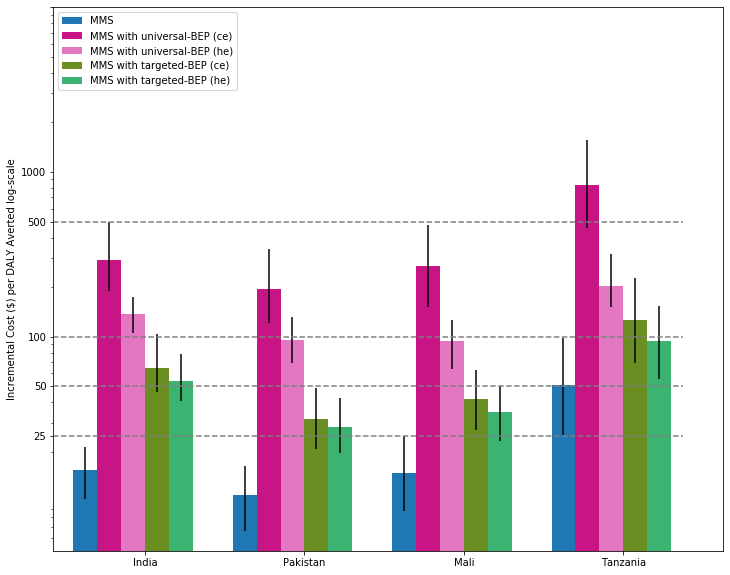

In [24]:
#LOG SCALE

data = master_avg #.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.15

# bar heights (y-axis) LOG
mmn = master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_upper =  master_avg['max'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)

#mmn = np.log(mmn)
# mmn_upper = np.log(mmn_upper)
# mmn_lower = np.log(mmn_lower)

bep_ce_universal = master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna()*(-1)
bep_ce_universal_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1))
bep_ce_universal_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_ce_universal').dropna().values*(-1))

#bep_ce_universal = np.log(bep_ce_universal)
#bep_ce_universal_upper = np.log(bep_ce_universal_upper) 
#bep_ce_universal_lower = np.log(bep_ce_universal_lower)

bep_hd_universal = master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna()*(-1)
bep_hd_universal_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1))
bep_hd_universal_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_hd_universal').dropna().values*(-1))

#bep_hd_universal = np.log(bep_hd_universal)
#bep_hd_universal_upper = np.log(bep_hd_universal_upper)
#bep_hd_universal_lower = np.log(bep_hd_universal_lower)

bep_ce_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna()*(-1)
bep_ce_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1))
bep_ce_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_ce_targeted').dropna().values*(-1))

#bep_ce_targeted = np.log(bep_ce_targeted)
#bep_ce_targeted_upper = np.log(bep_ce_targeted_upper)
#bep_ce_targeted_lower = np.log(bep_ce_targeted_lower)

bep_hd_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna()*(-1)
bep_hd_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1))
bep_hd_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_hd_targeted').dropna().values*(-1))

#bep_hd_targeted = np.log(bep_hd_targeted)
#bep_hd_targeted_upper = np.log(bep_hd_targeted_upper)
#bep_hd_targeted_lower = np.log(bep_hd_targeted_lower)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# bar positions (for x-axis)
mmn_x = np.arange(len(mmn)) 
bep_ce_universal_x = [x + barWidth for x in mmn_x]
bep_hd_universal_x = [x + barWidth for x in bep_ce_universal_x]
bep_ce_targeted_x = [x + barWidth for x in bep_hd_universal_x ]
bep_hd_targeted_x = [x + barWidth for x in bep_ce_targeted_x]

# plot

plt.figure(figsize=(12,10))

plt.bar(mmn_x, mmn, yerr=[mmn_lower, mmn_upper], width=barWidth, label = 'MMS')
plt.bar(bep_ce_universal_x, bep_ce_universal, yerr=[bep_ce_universal_lower, bep_ce_universal_upper], width=barWidth, label = 'MMS with universal-BEP (ce)', color = 'mediumvioletred')
plt.bar(bep_hd_universal_x, bep_hd_universal, yerr=[bep_hd_universal_lower, bep_hd_universal_upper], width=barWidth, label = 'MMS with universal-BEP (he)', color = 'tab:pink')
plt.bar(bep_ce_targeted_x, bep_ce_targeted, yerr=[bep_ce_targeted_lower, bep_ce_targeted_upper], width=barWidth, label = 'MMS with targeted-BEP (ce)', color = 'olivedrab')
plt.bar(bep_hd_targeted_x, bep_hd_targeted, yerr=[bep_hd_targeted_lower, bep_hd_targeted_upper], width=barWidth, label = 'MMS with targeted-BEP (he)', color = 'mediumseagreen')

plt.legend(loc='upper left')

threshold4 = 500
threshold3 = 100
threshold2 = 50
threshold1 = 25

plt.plot([-0.25,len(mmn)-.25], [threshold1, threshold1],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold3, threshold3],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold4, threshold4],'k--', c='gray')

#
plt.yscale('log')
plt.axis([-0.2 , 4 , 0, 200])
plt.yticks([25,50,100,500,1000,10000],[25,50,100,500,1000]) #first argument says WHERE to put the ticks, second argument
#plt.yticklabels(['25','50','100','200','400','800',1600])

plt.xticks([r + 2.5*barWidth for r in range(len(mmn))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted log-scale')
#plt.title('Incremental Cost per DALY Averted Relative to Baseline (log scale)')
#plt.savefig('fig_ICERS_baseline')

y = [mmn, bep_ce_universal, bep_hd_universal, bep_ce_targeted, bep_hd_targeted]
y_upper = [mmn_upper, bep_ce_universal_upper, bep_hd_universal_upper, bep_ce_targeted_upper, bep_hd_targeted_upper]
print(y)

